# Representing the dot/inner product through an MLP

Dot products are commonly used in recommender systems to combine user and item embeddings.

The dot product of two vectors (A and B) is the sum of the products of their corresponding elements:
$$
\mathbf{a} \cdot \mathbf{b} = \langle \mathbf{a}, \mathbf{b} \rangle = \sum_{i=1}^{n} a_i b_i
$$


Dense layers in a neural network work on the weighted sum of inputs. They dont directly capture interactions between features. We can concat two vector and push through a dense layer. The output of a dense layer is given as:
$$
g([\mathbf{a} , \mathbf{b}]) = \sigma(\mathbf{W} \cdot ([\mathbf{a} , \mathbf{b}]) + \mathbf{c})
$$

Where $[,]$ is the concatenation operation and $\mathbf{W}$ and $\mathbf{c}$ are the weight matrix and bias of the dense layer, respectively.

In this notebook, we will explore how to represent the dot product using a neural network

## TODO
1. Create a model training framework
2. Deep vs shallow
3. data loader to create random dot product samples
4. overfit small sample, with high epoch count
   1. is learning rate correct?

## Setup
```
uv add pytorch-lightning
uv run mlflow ui --backend-store-uri experiments
```

## Model definition

In [1]:
from typing import List
import pytorch_lightning as pyl
import torch
import torch.nn as nn


class Model(pyl.LightningModule):
    def __init__(
        self,
        dimension: int,
        layer_sizes: List[int] = [32, 16],
        learning_rate: float = 5e-3,
        incl_multiplication: bool = False,
    ):
        super().__init__()

        self.incl_multiplication = incl_multiplication
        input_layer_size = dimension * 3 if incl_multiplication else dimension * 2
        if layer_sizes is None:
            self.output = nn.Linear(input_layer_size, 1)
            # self.output.weight.data.fill_(1.0)
            # self.output.bias.data.fill_(0.0)
        else:
            layer_sizes = [input_layer_size] + layer_sizes + [1]
            layers = []
            for i in range(len(layer_sizes) - 1):
                layers.append(nn.Linear(layer_sizes[i], layer_sizes[i + 1]))
                layers.append(nn.ReLU())
            self.output = nn.Sequential(*layers, nn.Linear(layer_sizes[-1], 1))

        self.learning_rate = learning_rate
        self.save_hyperparameters()

    def forward(self, a, b):
        if self.incl_multiplication:
            return self.output(torch.cat([a, b, a * b], dim=1)).flatten()
        else:
            return self.output(torch.cat([a, b], dim=1)).flatten()

    def training_step(self, batch, batch_idx):
        a, b, y = batch
        y_hat = self(a, b)
        loss = nn.MSELoss()(y_hat, y)
        self.log("train_loss", loss, on_step=True, on_epoch=True, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        a, b, y = batch
        y_hat = self(a, b)
        loss = nn.MSELoss()(y_hat, y)
        self.log("val_loss", loss, on_step=True, on_epoch=True, prog_bar=True)
        return loss

    def test_step(self, batch, batch_idx):
        a, b, y = batch
        y_hat = self(a, b)
        loss = nn.MSELoss()(y_hat, y)
        self.log("test_loss", loss, on_step=True, on_epoch=True, prog_bar=True)
        return loss

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.learning_rate)

## Generate data
We will make a dataset that creates a random pair of vectors and their dot product.
As the data is randomly generate each batch we don't need to be concerned with overfitting.
Therefore we have only a train dataloader.

In [2]:
from torch.utils.data import Dataset, DataLoader
import torch


class RandomVectorDataset(Dataset):
    def __init__(self, dimension: int, num_samples: int, seed: int = 42):
        self.seed = seed
        torch.manual_seed(seed)
        self.dimension = dimension
        self.num_samples = num_samples

        self.a = torch.randn(num_samples, dimension)
        self.b = torch.randn(num_samples, dimension)
        self.y = torch.sum(self.a * self.b, dim=1)

    def __len__(self):
        return self.num_samples

    def __getitem__(self, idx):
        return self.a[idx, :], self.b[idx, :], self.y[idx]


class RandomVectorDataset2(Dataset):
    def __init__(self, dimension: int, num_samples: int, seed: int = 42):
        self.seed = seed
        torch.manual_seed(seed)
        self.dimension = dimension
        self.num_samples = num_samples

    def __len__(self):
        return self.num_samples

    def __getitem__(self, idx):
        a = torch.randn(self.dimension)
        b = torch.randn(self.dimension)
        y = torch.dot(a, b)
        return a, b, y


dataset = RandomVectorDataset(dimension=1, num_samples=10)
dataloader = DataLoader(dataset, batch_size=4, shuffle=False)

for batch in dataloader:
    a, b, y = batch
    print(f"a: {a}")
    print(f"b: {b}")
    print(f"Dot Product: {y}")
    break  # Remove this break to iterate through the entire dataset

a: tensor([[0.3367],
        [0.1288],
        [0.2345],
        [0.2303]])
b: tensor([[ 0.5349],
        [ 0.8094],
        [ 1.1103],
        [-1.6898]])
Dot Product: tensor([ 0.1801,  0.1043,  0.2603, -0.3892])


## Train models

In [9]:
from pytorch_lightning.callbacks import EarlyStopping
from pytorch_lightning.loggers import MLFlowLogger


def setup_experiment():
    mlf_logger = MLFlowLogger(experiment_name="dot_product", tracking_uri="experiments")
    return mlf_logger


def train(model, dataloader):
    early_stopping = EarlyStopping(monitor="train_loss", patience=2, mode="min")
    mlf_logger = setup_experiment()
    trainer = pyl.Trainer(
        max_epochs=300,
        logger=mlf_logger,
        log_every_n_steps=1,
        callbacks=early_stopping,
    )
    trainer.fit(model, dataloader)

    return trainer.test(model, dataloader)


def train_loop(dimension: int, model_kwargs: dict = None):
    _model_kwargs = {"layer_sizes": [dimension * 2, dimension], "learning_rate": 1e-2}
    _model_kwargs.update(model_kwargs or {})

    # Create dataset and dataloader
    num_samples = 1_000_000
    num_samples = 1024
    batch_size = 1024
    dataset = RandomVectorDataset(dimension=dimension, num_samples=num_samples)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

    model = Model(dimension=dimension, **_model_kwargs)
    loss = train(model=model, dataloader=dataloader)
    return model, loss

In [23]:
# model, loss = train_loop(dimension=4, layers=[4, 2])
# model, loss = train_loop(dimension=4, layers=[4])
# model, loss = train_loop(dimension=4, layers=[16, 8, 4, 2])
# model, loss = train_loop(dimension=2, layers=[4, 2])
# model, loss = train_loop(dimension=1, layers=[2])
# model, loss = train_loop(dimension=2, layers=[16, 8, 4, 2])
# model, loss = train_loop(dimension=2, layers=[32, 32, 16, 16, 8, 8, 4, 4, 2, 2])
# model, loss = train_loop(dimension=2, layers=[4]*30)
# model, loss = train_loop(dimension=1, layers=[4]*100)
# model, loss = train_loop(dimension=1, layers=[1024, 512, 128, 64, 32])
# model, loss = train_loop(dimension=1)
# model, loss = train_loop(dimension=1, model_kwargs={"incl_multiplication": True})
# model, loss = train_loop(dimension=1, model_kwargs={"layer_sizes":[8, 8, 4, 4], "incl_multiplication": True})
# model, loss = train_loop(
#     dimension=1,
#     model_kwargs={"layer_sizes": [16, 8, 8, 4, 4], "incl_multiplication": True, 'learning_rate': 1e-2},
# )
# model, loss = train_loop(
#     dimension=1, model_kwargs={"layer_sizes": None, "incl_multiplication": True}
# )
model, loss = train_loop(
    dimension=1, model_kwargs={"layer_sizes": [1] * 30, "incl_multiplication": True}
)
# model, loss = train_loop(dimension=1, layers=[10000, 512, 128, 64, 32])
# model, loss = train_loop(dimension=1, layers=[64, 32, 16, 8, 4, 2])
# model, loss = train_loop(dimension=1, layers=None)
# model, loss = train_loop(dimension=2, layers=None)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name   | Type       | Params | Mode 
----------------------------------------------
0 | output | Sequential | 66     | train
----------------------------------------------
66        Trainable params
0         Non-trainable params
66        Total params
0.000     Total estimated model params size (MB)
64        Modules in train mode
0         Modules in eval mode


Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 149.32it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     test_loss_epoch         0.96002197265625
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


In [72]:
list(model.parameters())

[Parameter containing:
 tensor([[ 0.6321,  0.6314,  0.3821],
         [ 0.8511,  0.9255, -0.3002],
         [-0.2286, -0.2052,  0.8763],
         [-0.4934, -0.4419, -0.6459]], requires_grad=True),
 Parameter containing:
 tensor([ 0.2503,  0.0763,  1.2434, -0.0285], requires_grad=True),
 Parameter containing:
 tensor([[ 0.8136, -0.3749,  1.2269, -0.4511]], requires_grad=True),
 Parameter containing:
 tensor([0.7480], requires_grad=True),
 Parameter containing:
 tensor([[0.7036]], requires_grad=True),
 Parameter containing:
 tensor([-1.6541], requires_grad=True)]

## Results

In [30]:
runs

[]

/var/folders/ky/4qby95090jbbq38_mh94x72r0000gn/T/ipykernel_30302/2643683158.py:31: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


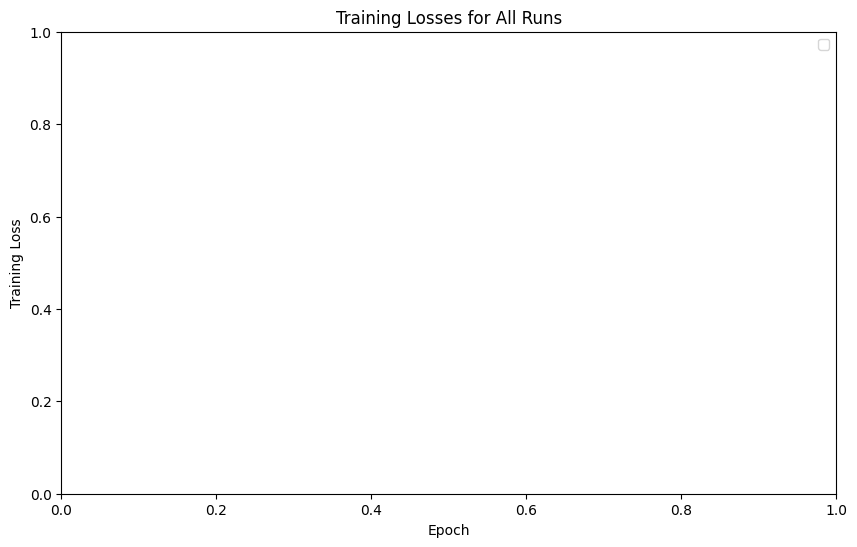

In [29]:
# load all mlflow final epoch loss
# plot against architecture and dimension

import mlflow
import pandas as pd
import matplotlib.pyplot as plt

# Set the experiment ID or name
experiment_id = "dot_product"
# mlf_logger = MLFlowLogger(experiment_name="dot_product", tracking_uri="experiments")

# Load all runs from the experiment
client = mlflow.tracking.MlflowClient(tracking_uri="experiments")
runs = client.search_runs(experiment_ids=[experiment_id])

# Extract training losses
losses = {}
for run in runs:
    run_id = run.info.run_id
    metrics = client.get_metric_history(run_id, "training_loss")
    losses[run_id] = [metric.value for metric in metrics]

# Plot the training losses
plt.figure(figsize=(10, 6))
for run_id, loss_values in losses.items():
    plt.plot(loss_values, label=f"Run {run_id}")

plt.xlabel("Epoch")
plt.ylabel("Training Loss")
plt.title("Training Losses for All Runs")
plt.legend()
plt.show()

### Conclusion

